# Parameterisation for Pb flux from atmosphere

#### World Data Centre for Aerosols
http://ebas.nilu.no, file format is NASA Ames. Converted to a NetCDF file using notebook read_NASA_ames.ipynb.

Relevant stations: Alert (Nunavut), Summit (Greenland), Villum (Northern Greenland); only data available for both EBC and Pb at Alert. 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import datetime
from matplotlib.dates import date2num, num2date
import matplotlib
import netCDF4 as nc
import calendar
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq
from scipy.signal import correlate
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import xarray as xr

%matplotlib inline

In [7]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

In [8]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    """

    if x.ndim != 1:
        raise ValueError#, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError#, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError#, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

#### Load data:

In [11]:
Alert     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Alert_1989-1992.nc')
EBC       = Alert['EBC'].values
EBC_dates = Alert['EBC_dates'].values
Pb        = Alert['Pb'].values
Pb_dates  = Alert['Pb_dates'].values

# Relation between Pb in Black Carbon:

### Method 1: Running average

In [21]:
Pb_ave = smooth(Pb, window_len=6, window='flat')
EBC_ave = smooth(EBC, window_len=1000, window='flat')

Text(0, 0.5, 'Lead (ng/m3)')

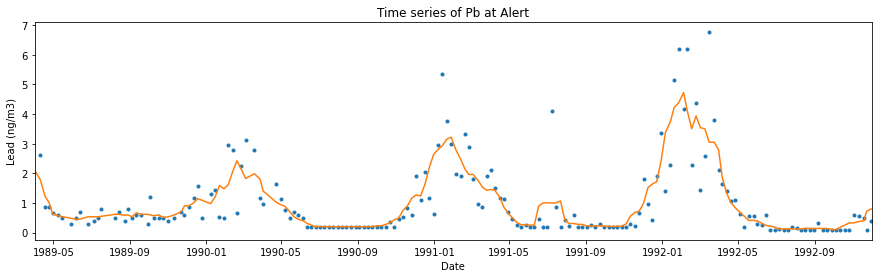

In [22]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(Pb_dates, Pb,'.')
ax1.plot_date(Pb_dates, Pb_ave[3:-2],'-')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of Pb at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lead (ng/m3)')

Text(0, 0.5, 'Equivalent black carbon (ug/m3)')

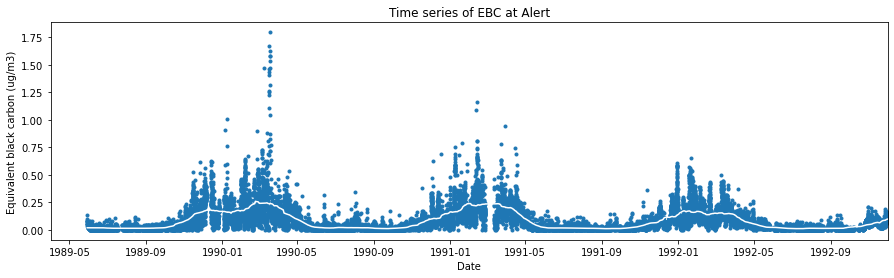

In [23]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(EBC_dates, EBC, '.')
ax1.plot_date(EBC_dates, EBC_ave[500:24935],'-w')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of EBC at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Equivalent black carbon (ug/m3)')

Interpolate running averages onto time grid:

In [24]:
EBC_dates_d = num2date(EBC_dates)
Pb_dates_d = num2date(Pb_dates)

In [25]:
base = EBC_dates_d[0]
diff = (EBC_dates_d[-1] - base)
time_grid = [base + datetime.timedelta(days=x) for x in range(0, diff.days)] # interpolated to daily values 

In [26]:
t1_EBC = np.array([toTimestamp(t) for t in EBC_dates_d])
t1_Pb = np.array([toTimestamp(t) for t in Pb_dates_d])
EBC_int = EBC_ave[500:24935]
Pb_int = Pb_ave[5:204]

EBC_grid = np.interp([toTimestamp(t) for t in time_grid], t1_EBC, EBC_int)
Pb_grid = np.interp([toTimestamp(t) for t in time_grid], t1_Pb, Pb_int)

In [27]:
Pb_grid1989 = Pb_grid[0:216]
Pb_grid1990 = Pb_grid[216:581]
Pb_grid1991 = Pb_grid[581:946]
Pb_grid1992 = Pb_grid[946:-1]
EBC_grid1989 = EBC_grid[0:216]
EBC_grid1990 = EBC_grid[216:581]
EBC_grid1991 = EBC_grid[581:946]
EBC_grid1992 = EBC_grid[946:-1]

In [28]:
plt.rcParams['font.family'] = 'arial'
sns.set(rc={'axes.facecolor':'white', 'axes.grid':'false', 'axes.edgecolor':'black', 'axes.linewidth':'1', \
           'xtick.major.size':'6', 'ytick.major.size':'6', 'xtick.minor.size':'4', 'ytick.minor.size':'4', \
           })
sns.set_context('poster')
# sns.axes_style()

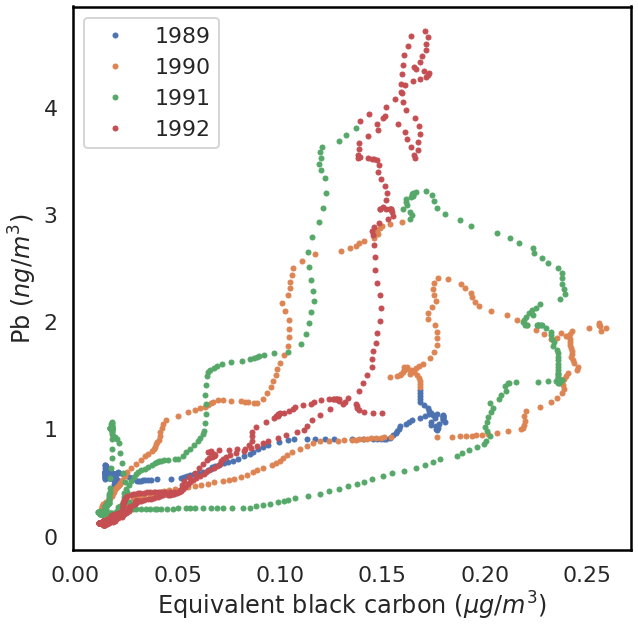

In [29]:
fig,ax1 = plt.subplots(figsize=(10,10))
ax1.plot(EBC_grid1989, Pb_grid1989,  '.', label='1989', markersize=10)
ax1.plot(EBC_grid1990, Pb_grid1990, '.', label='1990', markersize=10)
ax1.plot(EBC_grid1991, Pb_grid1991,  '.', label='1991', markersize=10)
ax1.plot(EBC_grid1992, Pb_grid1992, '.', label='1992', markersize=10)
# ax1.set_title('Time series from 1989-1992 at Alert')
ax1.set_ylabel('Pb ($ng/m^3$)')
ax1.set_xlabel('Equivalent black carbon ($\mu g/m^3$)')
ax1.legend(loc=2)
fig.savefig('pb_bc.png', bbox_inches='tight')

In [30]:
print('Pearson r value: '+ str(pearsonr(EBC_grid, Pb_grid)))

Pearson r value: (0.6917299542453688, 2.0406787701268535e-187)


In [31]:
print('Spearman r value: '+ str(spearmanr(EBC_grid, Pb_grid))) # rank correlation

Spearman r value: SpearmanrResult(correlation=0.8074763551471932, pvalue=1.430716625542728e-302)


#### Fit a linear regression:

In [32]:
from scipy.optimize import leastsq

In [33]:
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x  
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. ) using the error function
    p1, success = leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1, f  

In [40]:
p1, f = lin_fit(EBC_grid*1e-6, Pb_grid*1e-9)
print(p1)
print(f)

[0.01108231]
[2.14510947e-10 2.14998790e-10 2.13702271e-10 ... 1.61294231e-09
 1.65994693e-09 1.72029475e-09]


In [41]:
1/p1

array([90.23390301])

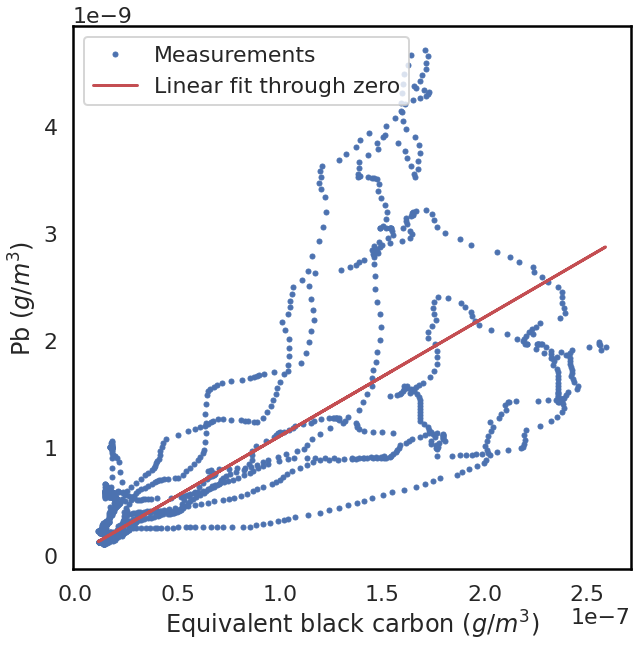

In [38]:
fig,ax1 = plt.subplots(figsize=(10,10))
ax1.plot(EBC_grid*1e-6, Pb_grid*1e-9,  '.', label='Measurements', markersize=10)
ax1.plot(EBC_grid*1e-6, f*1e-9, 'r', label="Linear fit through zero")
# ax1.set_title('Time series from 1989-1992 at Alert')
ax1.set_ylabel('Pb ($g/m^3$)')
ax1.set_xlabel('Equivalent black carbon ($g/m^3$)')
ax1.legend(loc=2)

###### So, the ratio to use for EBC to Pb is 1:11

### Method 2: bandpass filter

1) Black carbon:

In [142]:
dt_EBC = (EBC_dates_d[1]-EBC_dates_d[0]).total_seconds()
amp_EBC = np.fft.rfft(EBC)
freqs_EBC = np.fft.rfftfreq(EBC.size,dt_EBC)
phase_EBC = (np.arctan2(amp_EBC.imag,amp_EBC.real))

Text(0,0.5,'Magnitude')

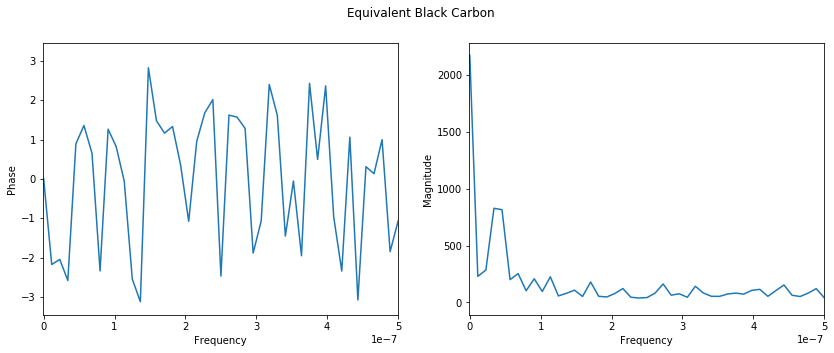

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5))
fig.suptitle('Equivalent Black Carbon')

ax1.plot(freqs_EBC, phase_EBC)
ax1.set_xlim([-1e-9,5e-7])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Phase')

ax2.plot(freqs_EBC, np.abs(amp_EBC))
ax2.set_xlim([-1e-9,5e-7])
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Magnitude')

In [96]:
# Apply bandpass filter:
filter_EBC = amp_EBC.copy()
filter_EBC[(freqs_EBC > 3e-7)] = 0
EBC_filtered = np.fft.irfft(filter_EBC)

Text(0,0.5,'Equivalent black carbon (ug/m3)')

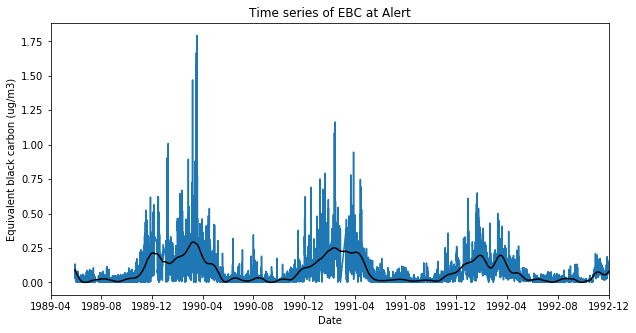

In [97]:
fig,ax1 = plt.subplots(figsize=(10,5))
ax1.plot_date(EBC_dates, EBC, '-')
ax1.plot_date(EBC_dates[0:-1], EBC_filtered,'-k')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of EBC at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Equivalent black carbon (ug/m3)')

2) Pb:

In [98]:
dt_Pb    = (Pb_dates_d[1]-Pb_dates_d[0]).total_seconds()
amp_Pb   = np.fft.rfft(Pb)
freqs_Pb = np.fft.rfftfreq(Pb.size,dt_Pb)
phase_Pb = (np.arctan2(amp_Pb.imag,amp_Pb.real))

Text(0,0.5,'Magnitude')

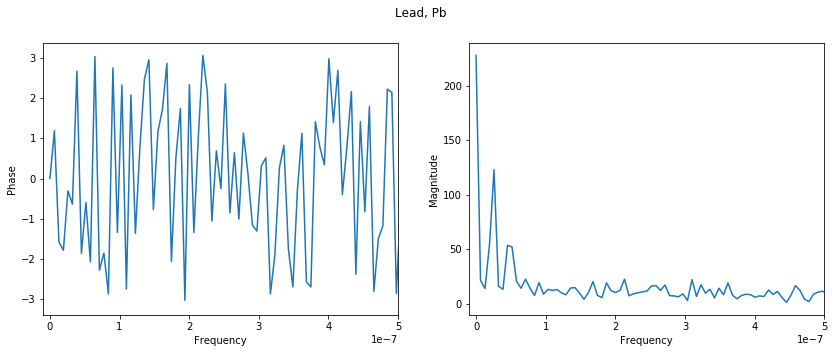

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,5))
fig.suptitle('Lead, Pb')

ax1.plot(freqs_Pb, phase_Pb)
ax1.set_xlim([-1e-8,5e-7])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Phase')

ax2.plot(freqs_Pb, np.abs(amp_Pb))
ax2.set_xlim([-1e-8,5e-7])
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Magnitude')

In [128]:
# Apply bandpass filter:
filter_Pb = amp_Pb.copy()
filter_Pb[(freqs_Pb > 2e-7)] = 0
Pb_filtered = np.fft.irfft(filter_Pb)

Text(0,0.5,'Lead (ng/m3)')

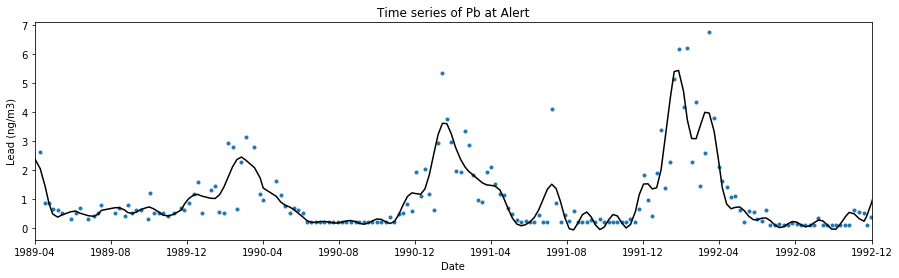

In [129]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(Pb_dates, Pb,'.')
ax1.plot_date(Pb_dates[0:-1], Pb_filtered,'-k')
ax1.set_xlim([datetime.datetime(1989,4,1), datetime.datetime(1992,12,1)])
ax1.set_title('Time series of Pb at Alert')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lead (ng/m3)')

Now interpolate to the same dates:

In [130]:
base = EBC_dates_d[0]
diff = (EBC_dates_d[-1] - base)
time_grid = [base + datetime.timedelta(days=x) for x in range(0, diff.days)] # interpolated to daily values 

In [131]:
t2_EBC = np.array([toTimestamp(t) for t in EBC_dates_d])
t2_Pb = np.array([toTimestamp(t) for t in Pb_dates_d])

EBC_filtered_grid = np.interp([toTimestamp(t) for t in time_grid], t2_EBC[0:-1], EBC_filtered)
Pb_filtered_grid = np.interp([toTimestamp(t) for t in time_grid], t2_Pb[0:-1], Pb_filtered)

Text(0.5,0,'Equivalent black carbon (ug/m3)')

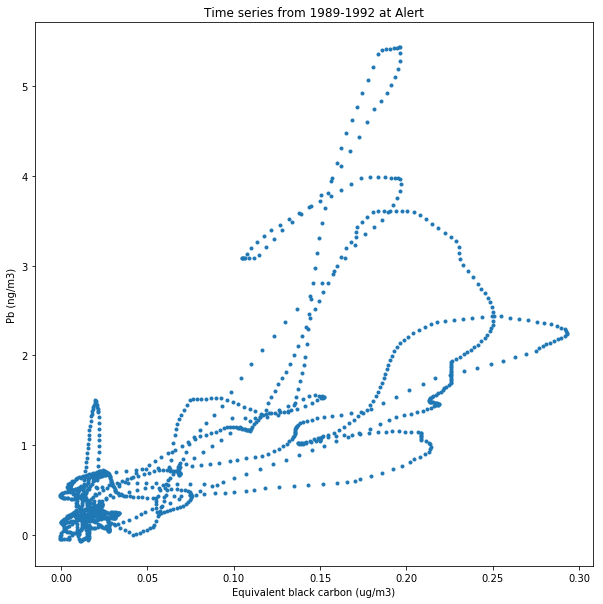

In [132]:
fig,ax1 = plt.subplots(figsize=(10,10))
ax1.plot(EBC_filtered_grid, Pb_filtered_grid, '.')
ax1.set_title('Time series from 1989-1992 at Alert')
ax1.set_ylabel('Pb (ng/m3)')
ax1.set_xlabel('Equivalent black carbon (ug/m3)')

In [133]:
print('Pearson r value: '+ str(pearsonr(EBC_filtered_grid, Pb_filtered_grid)))

Pearson r value: (0.73418930023719342, 1.5146084795341526e-222)


In [134]:
print('Spearman r value: '+ str(spearmanr(EBC_filtered_grid, Pb_filtered_grid))) # rank correlation

Spearman r value: SpearmanrResult(correlation=0.78903849219219868, pvalue=1.8404586863577716e-279)


### Look into hysteresis:

In [135]:
print(np.average(phase_EBC))
print(np.average(phase_Pb))

0.0314953899128
0.0982535812354


Text(0.5,1,'Compare the phase:')

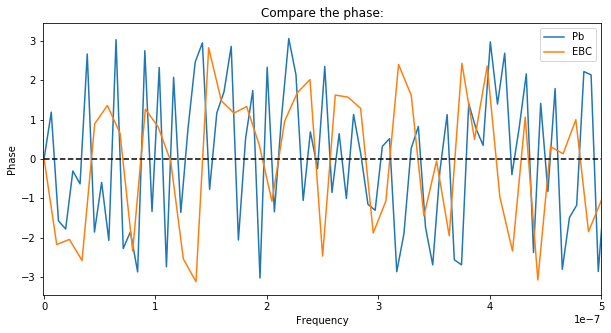

In [151]:
plt.subplots(figsize=(10,5))
plt.plot(freqs_Pb, phase_Pb, label='Pb')
plt.plot(freqs_EBC, phase_EBC, label='EBC')
plt.plot([0, 5e-7], [0, 0], '--k')
plt.xlim([-1e-9,5e-7])
plt.xlabel('Frequency')
plt.ylabel('Phase')
plt.legend()
plt.title('Compare the phase:')